In [1]:
import datetime
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import calendar

%matplotlib inline

# Introduction

This is a exploratory data analysis for the Kaggle competition [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting).

The purpose of this challenge is to use reservation and visitation data to predict the total number of restaurant visitors for future days. The Japanese restaurants are owned by [Recruit Holdings](http://www.recruit-rgf.com/meet_recruit/).

#### Datasets

Available datasets come from following sources:
* Hot Pepper Gourmet (a restaurant review service)
* AirREGI (a restaurant point of sales service)
* Restaurant Board (reservation log management software)

The datasets contain daily and hourly observations. This makes it a Time Series Forecasting problem.

#### Business background
One common predicament is that restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members. This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.

# Load Data

In [2]:
df_air_reserve =       pd.read_csv("../data/raw/air_reserve.csv", parse_dates=['visit_datetime', 'reserve_datetime'])
df_air_store_info =    pd.read_csv("../data/raw/air_store_info.csv")
df_air_visit_data =    pd.read_csv("../data/raw/air_visit_data.csv", parse_dates=['visit_date'])

df_hpg_reserve =       pd.read_csv("../data/raw/hpg_reserve.csv", parse_dates=['visit_datetime', 'reserve_datetime'])
df_hpg_store_info =    pd.read_csv("../data/raw/hpg_store_info.csv")

df_date_info =         pd.read_csv("../data/raw/date_info.csv", parse_dates=['calendar_date'])
df_store_id_relation = pd.read_csv("../data/raw/store_id_relation.csv")

df_sample_submission = pd.read_csv("../data/raw/sample_submission.csv")

# Overview: File structure and content

### Air Visits

In [3]:
df_air_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null datetime64[ns]
visitors        252108 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.8+ MB


In [4]:
df_air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


### Air Reserve

In [5]:
df_air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null datetime64[ns]
reserve_datetime    92378 non-null datetime64[ns]
reserve_visitors    92378 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.8+ MB


In [6]:
df_air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


### Air Store Info

In [7]:
df_air_store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [8]:
df_air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


### HPG Reserve

In [9]:
df_hpg_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
hpg_store_id        object
visit_datetime      datetime64[ns]
reserve_datetime    datetime64[ns]
reserve_visitors    int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 61.0+ MB


In [10]:
df_hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


### HPG Store Info

In [11]:
df_hpg_store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
hpg_store_id      4690 non-null object
hpg_genre_name    4690 non-null object
hpg_area_name     4690 non-null object
latitude          4690 non-null float64
longitude         4690 non-null float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


In [12]:
df_hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


### Date Info

In [13]:
df_date_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
calendar_date    517 non-null datetime64[ns]
day_of_week      517 non-null object
holiday_flg      517 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.2+ KB


In [14]:
df_date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


### Sample Submission

In [15]:
df_sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 2 columns):
id          32019 non-null object
visitors    32019 non-null int64
dtypes: int64(1), object(1)
memory usage: 500.4+ KB


In [16]:
df_sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


# Individual Feature Visualization

#### DATA PREPROCESSING

In [17]:
# set DateTime index to perform visualizations
df_date_info.set_index('calendar_date', inplace=True)

df_holidays = df_date_info[df_date_info['holiday_flg'] == True]

In [18]:
df_holidays.head()

,day_of_week,holiday_flg
calendar_date,,
2016-01-01,Friday,1
2016-01-02,Saturday,1
2016-01-03,Sunday,1
2016-01-11,Monday,1
2016-02-11,Thursday,1


## Air Visits

In [19]:
# set DateTime index to perform visualizations
df_air_visit_data.set_index('visit_date', inplace=True)

#### STATISTICS ON NUMBER OF VISITORS PER DAY IN THE WHOLE TIME FRAME

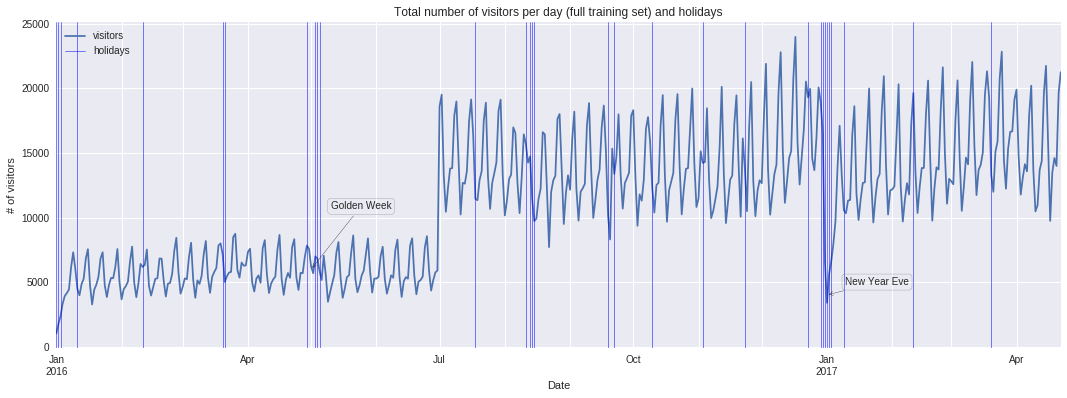

In [20]:
# display statistics per day
visits_daily = df_air_visit_data.resample('D').sum()
ax = visits_daily.plot(figsize=(18,6), title='Total number of visitors per day (full training set) and holidays');

# display holidays
for index, row in df_holidays.iterrows():
    ax.axvline(x=index, color='b', linewidth=0.5, label='holidays');

# plot styling
ax.set_xlabel("Date")
ax.set_ylabel("# of visitors");

ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')
    
ax.legend(['visitors', 'holidays']);

# Add labels to the plot
ax.annotate("Golden Week", xy=('2016-05-01', 6000),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(50, 60), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"));

ax.annotate("New Year Eve", xy=('2017-01-01', 4000),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(50, 10), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"));

#### STATISTICS ON NUMBER OF VISITORS PER MONTH

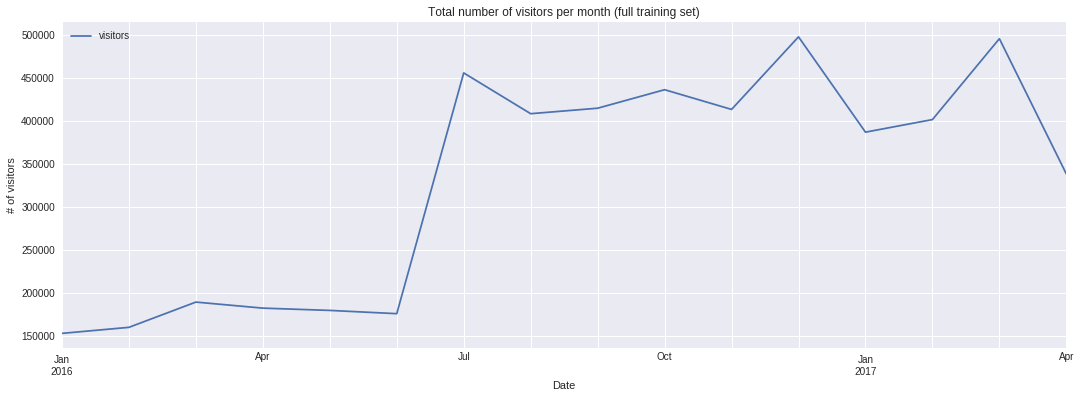

In [21]:
# display statistics per month
visits_monthly = df_air_visit_data.resample('M').sum()
ax = visits_monthly.plot(figsize=(18,6), title='Total number of visitors per month (full training set)');

ax.set_xlabel("Date")
ax.set_ylabel("# of visitors");

ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')

#### MOST COMMON NUMBER OF VISITORS PER RESTAURANT PER DAY

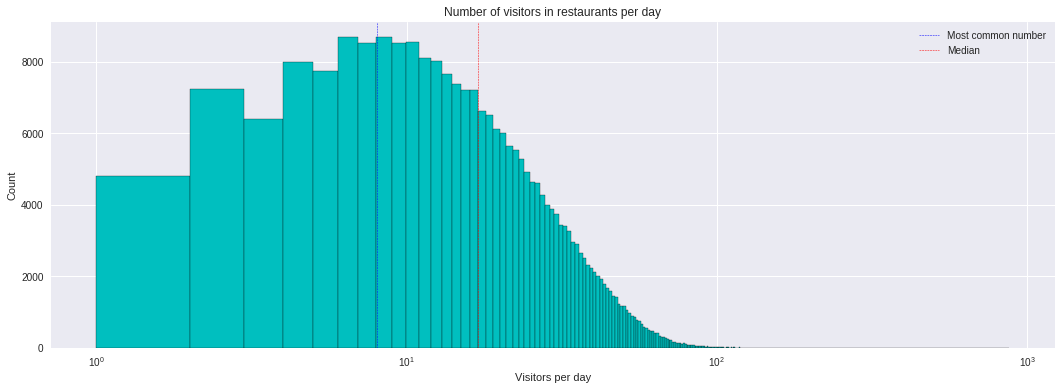

In [22]:
# determine number of bins to use
bin_counts = np.bincount(df_air_visit_data['visitors'])

# display bins
ax = df_air_visit_data['visitors'].hist(bins=len(bin_counts), figsize=(18,6), color='c', edgecolor='black');

# display mode (most common value)
ax.axvline(x=np.argmax(bin_counts), color='b', linewidth=0.5, linestyle='dashed');
# display median
ax.axvline(x=df_air_visit_data['visitors'].median(), color='r', linewidth=0.5, linestyle='dashed');

# plot styling
ax.set_xscale('log')

ax.set_title("Number of visitors in restaurants per day")
ax.set_xlabel("Visitors per day")
ax.set_ylabel("Count");

ax.legend(['Most common number', 'Median']);

In [23]:
print("Most common number of visitors in restaurants per day is {0} (occurred {1} times)." \
          .format(np.argmax(bin_counts), np.max(bin_counts)))

print("\nMedian number of visitors in restaurants per day is {0}." \
          .format(df_air_visit_data['visitors'].median()))

print("\nAverage number of visitors in restaurants per day is {0}, std: {1}." \
          .format(df_air_visit_data['visitors'].mean(),
                 df_air_visit_data['visitors'].std()))

print("\nMin and Max numbers of visitors in restaurants per day are {0} and {1}." \
          .format(df_air_visit_data['visitors'].min(),
                 df_air_visit_data['visitors'].max()))

Most common number of visitors in restaurants per day is 8 (occurred 8685 times).

Median number of visitors in restaurants per day is 17.0.

Average number of visitors in restaurants per day is 20.973761245180636, std: 16.757007314184705.

Min and Max numbers of visitors in restaurants per day are 1 and 877.


#### STATISTICS ON NUMBER OF VISITORS PER RESTAURANT PER WEEKDAY

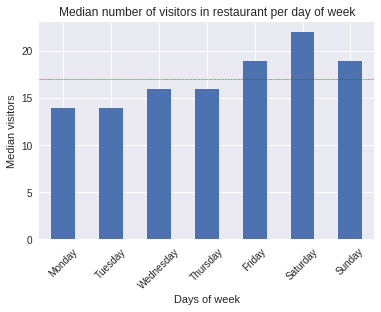

In [24]:
# create new columns
df_air_visit_data['visit_date'] = df_air_visit_data.index
df_air_visit_data['weekday'] = df_air_visit_data['visit_date'].dt.dayofweek
df_air_visit_data['weekday_name'] = df_air_visit_data['visit_date'].dt.weekday_name

# group data by weekday
visits_per_weekday = \
    df_air_visit_data[['weekday', 'weekday_name', 'visitors']] \
        .groupby(['weekday', 'weekday_name']) \
        .agg(['median']) \
        .sort_index(ascending=True)

# display data
ax = visits_per_weekday.plot(kind='bar')

# plot styling
ax.set_title("Median number of visitors in restaurant per day of week")
ax.set_xlabel("Days of week")
ax.set_ylabel("Median visitors");
ax.legend_.remove()

ax.set_xticklabels(list(calendar.day_name), rotation=45);
ax.axhline(y=df_air_visit_data['visitors'].median(), color='r', linewidth=0.5, linestyle='dashed');

#### STATISTICS ON NUMBER OF VISITORS PER RESTAURANT PER MONTH

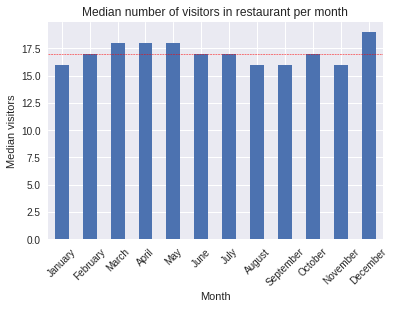

In [25]:
# create new columns
df_air_visit_data['month'] = df_air_visit_data['visit_date'].dt.month

# group data by weekday
visits_per_weekday = \
    df_air_visit_data[['month', 'visitors']] \
        .groupby(['month']) \
        .agg(['median']) \
        .sort_index(ascending=True)

# display data
ax = visits_per_weekday.plot(kind='bar')

# plot styling
ax.set_title("Median number of visitors in restaurant per month")
ax.set_xlabel("Month")
ax.set_ylabel("Median visitors");
ax.legend_.remove()

ax.set_xticklabels(list(calendar.month_name)[1:], rotation=45);
ax.axhline(y=df_air_visit_data['visitors'].median(), color='r', linewidth=0.5, linestyle='dashed');

#### DATA INTERPRETATION
By looking at data visualization we can find:

* Significant change in number of visitors. It was around 6000 people per month until July 2016. Since then it changed to approx. 15000. The reason is unknown, but it may be a result of opening new restaurants, of connecting existing restaurants to the AirREGI (a restaurant point of sales service) etc.

* The similar conclusion can be drawn from the monthly statistics of visitors when we can notice around 170000 visitors in all restaurants per month. Since July 2016 it surged up to around 430000 guests per month.

* Huge drop in number of customers in the very end of 2016 and beginning of 2017. This is most caused by New Year Eve and subsequent Japanese holidays (Jan 1-3)[https://www.timeanddate.com/holidays/japan/2017].

* The Japanese [Golden Week](https://en.wikipedia.org/wiki/Golden_Week_(Japan)) can be noticed in slightly reduced number of customers around 29th of April and first days of May.

* The staticstics for number of guests (per visit in restaurant):
    * a median is 17
    * a mode (most common number) is 8
    * an average is 20.97 with standard deviation: 16.76
    * a minimum is 1 and maximum is 877.

* Friday, Saturday and Sunday appear to be the most busy days (19 - 22 guests per day). Monday and Tuesday have the lowest number of guests - 14. The observed pattern is similar to the one in Europe.

* By looking at yearly statistics we can notice some amount of variation. The most popular month is December, least popular are January, August, September and November. The period of March - May is consistently busy.

## Air Reservations

In [26]:
# create new columns
df_air_reserve['visit_datetime_weekdayname'] = df_air_reserve['visit_datetime'].dt.weekday_name
df_air_reserve['reserve_datetime_weekdayname'] = df_air_reserve['reserve_datetime'].dt.weekday_name
df_air_reserve['reserve_datetime_hour'] = df_air_reserve['reserve_datetime'].dt.hour

df_air_reserve['visit_datetime_month'] = df_air_reserve['visit_datetime'].dt.month
df_air_reserve['reserve_datetime_month'] = df_air_reserve['reserve_datetime'].dt.month

#### STATISTICS ON HOURLY TRENDS FOR BOOKING RESERVATIONS

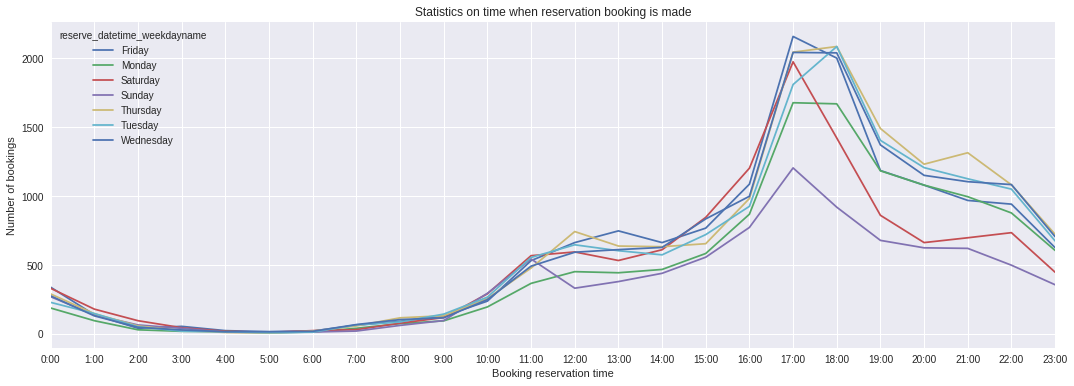

In [27]:
air_reserve_byhour_byweekday = \
    df_air_reserve.pivot_table(index=df_air_reserve['reserve_datetime'].dt.hour, 
    columns='reserve_datetime_weekdayname', 
    values='reserve_datetime_hour', 
    aggfunc='count')

ax = air_reserve_byhour_byweekday.plot(
        figsize=(18,6), 
        title='Statistics on time when reservation booking is made',
        xticks=np.arange(0, 24, 1))

ax.set_xlabel("Booking reservation time")
ax.set_ylabel("Number of bookings");

# display hours as labels on the X axis 
def format_func(value, tick_number):
    return "{0}:00".format(value);
    
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

#### STATISTICS ON HOURLY TRENDS FOR VISITS IN RESTAURANTS

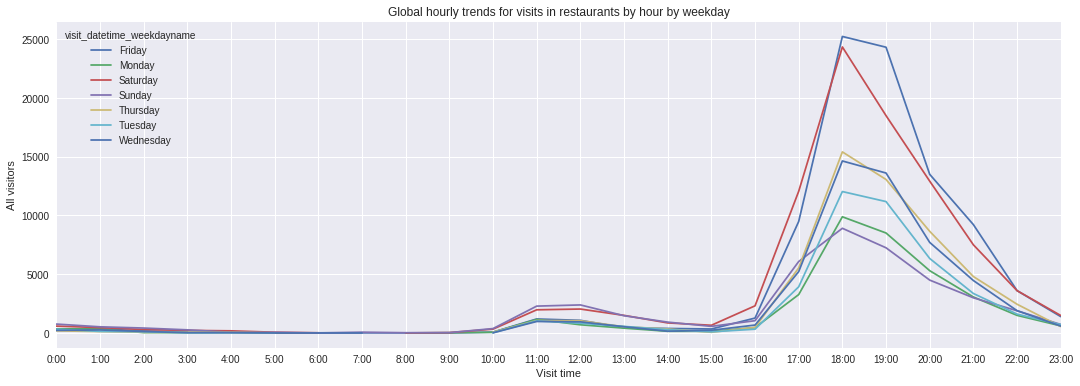

In [28]:
air_visit_byhour_byweekday = \
    df_air_reserve.pivot_table(index=df_air_reserve['visit_datetime'].dt.hour, 
    columns='visit_datetime_weekdayname', 
    values='reserve_visitors', 
    aggfunc='sum')

ax = air_visit_byhour_byweekday.plot(
        figsize=(18,6), 
        title='Global hourly trends for visits in restaurants by hour by weekday',
        xticks=np.arange(0, 24, 1))
 
ax.set_xlabel("Visit time")
ax.set_ylabel("All visitors");

# display hours as labels on the X axis 
def format_func(value, tick_number):
    return "{0}:00".format(value);
    
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

#### RESERVATION DATA VS ACTUAL VISITOR NUMBERS

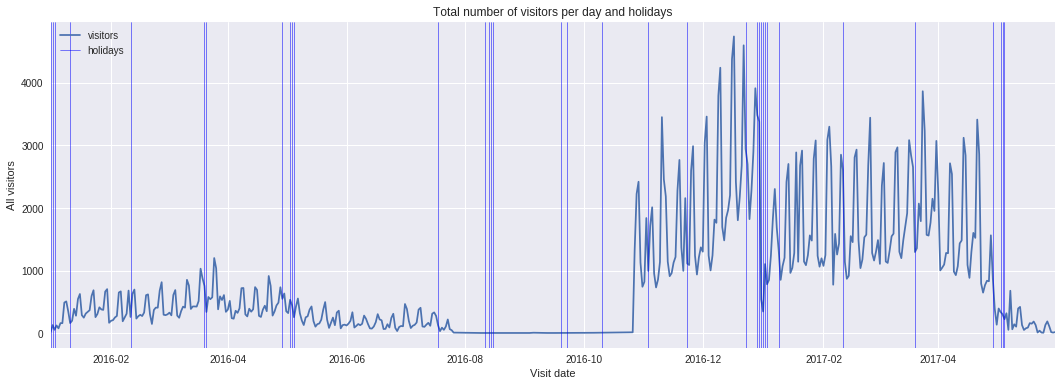

In [29]:
# prepare dataset
air_reservations = pd.DataFrame()
air_reservations['visit_date'] = df_air_reserve['visit_datetime'].dt.date
air_reservations['reserve_visitors'] = df_air_reserve['reserve_visitors']

# reservations by weekday
air_reservations_per_weekday = \
    air_reservations[['visit_date', 'reserve_visitors']] \
        .groupby(['visit_date']) \
        .agg(['sum']) \
        .sort_index(ascending=True)

# display data
ax = air_reservations_per_weekday.plot(figsize=(18,6))

# display holidays
for index, row in df_holidays.iterrows():
    ax.axvline(x=index, color='b', linewidth=0.5);

# plot styling
ax.set_title("Total number of visitors per day and holidays")
ax.set_xlabel("Visit date")
ax.set_ylabel("All visitors");

ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')
    
ax.legend(['visitors', 'holidays']);

#### TIME FROM RESERVATION TO VISIT

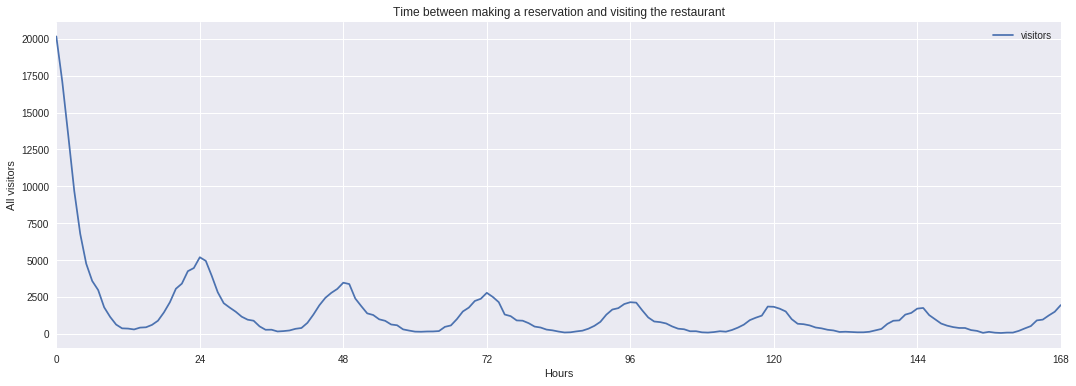

In [30]:
df_air_reserve['reserve_visit_diff'] = \
    (df_air_reserve['visit_datetime'] - df_air_reserve['reserve_datetime']) / np.timedelta64(1, 'h')

one_week_timespan = 7 * 24
    
air_reserve_visit_diff = \
    df_air_reserve[df_air_reserve['reserve_visit_diff'] <= one_week_timespan][['reserve_visit_diff', 'reserve_visitors']] \
        .groupby(['reserve_visit_diff']) \
        .agg(['sum']) \
        .sort_index(ascending=True)          

# display data
ax = air_reserve_visit_diff.plot(figsize=(18,6))

# plot styling
ax.set_title("Time between making a reservation and visiting the restaurant")
ax.set_xlabel("Hours")
ax.set_ylabel("All visitors");
    
ax.legend(['visitors', 'holidays']);

import matplotlib.ticker as ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

#### DATA INTERPRETATION
By looking at data visualization we can find:

* People usually are booking reservations around 16:00 - 19:00. Interestingly, no reservation booking was made between 4:00 and 5:00. Apparently there are no early birds in Japan :) 

* The least popular day for booking reservation is Sunday, as probably people are simply spending time with their family.

* The most popular time to sit down at restaurant and dine is 18:00 - 19:00.

* There were much fewer reservations made in 2016 through the AIR system than in 2017. Interestingly, there was no reservation booking between August and November 2016. The popularity of the AIR system in May 2017 dropped significantly and reached levels from 2016.

* The time (in hours) between making a reservation and visiting the restaurants follow a nice 24-hour pattern. The most popular strategy is to reserve a couple of hours before the visit, but if the reservation is made more in advance then it seems to be common to book a table in the evening for one of the next evenings.

## HPG Reservations

In [31]:
# create new columns
df_hpg_reserve['visit_datetime_weekdayname'] = df_hpg_reserve['visit_datetime'].dt.weekday_name
df_hpg_reserve['reserve_datetime_weekdayname'] = df_hpg_reserve['reserve_datetime'].dt.weekday_name
df_hpg_reserve['reserve_datetime_hour'] = df_hpg_reserve['reserve_datetime'].dt.hour

df_hpg_reserve['visit_datetime_month'] = df_hpg_reserve['visit_datetime'].dt.month
df_hpg_reserve['reserve_datetime_month'] = df_hpg_reserve['reserve_datetime'].dt.month

#### STATISTICS ON HOURLY TRENDS FOR BOOKING RESERVATIONS

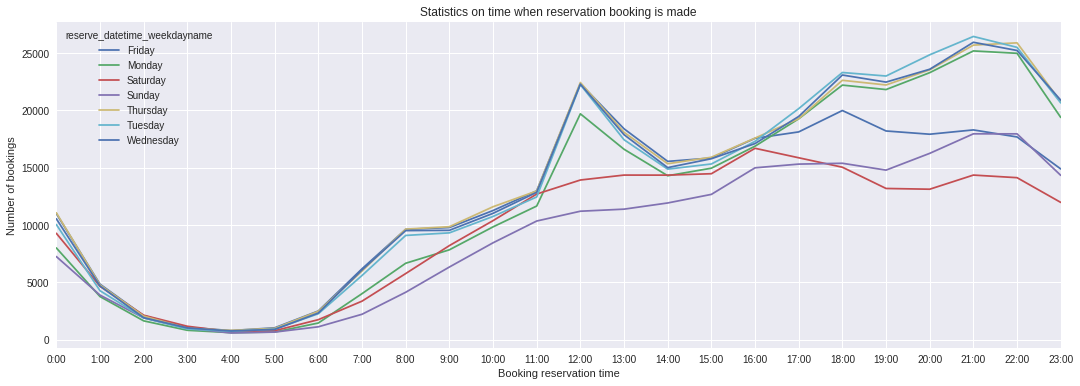

In [32]:
hpg_reserve_byhour_byweekday = \
    df_hpg_reserve.pivot_table(index=df_hpg_reserve['reserve_datetime'].dt.hour, 
    columns='reserve_datetime_weekdayname', 
    values='reserve_datetime_hour', 
    aggfunc='count')

ax = hpg_reserve_byhour_byweekday.plot(
        figsize=(18,6), 
        title='Statistics on time when reservation booking is made',
        xticks=np.arange(0, 24, 1))

ax.set_xlabel("Booking reservation time")
ax.set_ylabel("Number of bookings");

# display hours as labels on the X axis 
def format_func(value, tick_number):
    return "{0}:00".format(value);
    
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

#### STATISTICS ON HOURLY TRENDS FOR VISITS IN RESTAURANTS

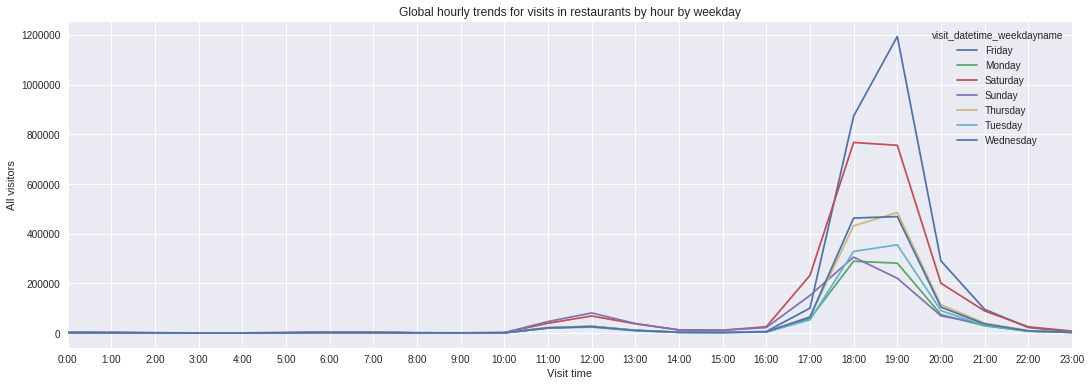

In [33]:
hpg_visit_byhour_byweekday = \
    df_hpg_reserve.pivot_table(index=df_hpg_reserve['visit_datetime'].dt.hour, 
    columns='visit_datetime_weekdayname', 
    values='reserve_visitors', 
    aggfunc='sum')

ax = hpg_visit_byhour_byweekday.plot(
        figsize=(18,6), 
        title='Global hourly trends for visits in restaurants by hour by weekday',
        xticks=np.arange(0, 24, 1))
 
ax.set_xlabel("Visit time")
ax.set_ylabel("All visitors");

# display hours as labels on the X axis 
def format_func(value, tick_number):
    return "{0}:00".format(value);
    
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

#### RESERVATION DATA VS ACTUAL VISITOR NUMBERS

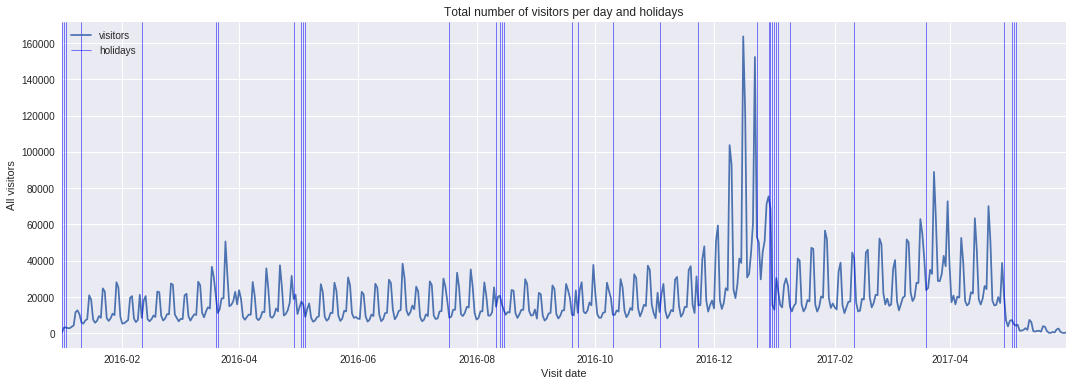

In [34]:
# prepare dataset
hpg_reservations = pd.DataFrame()
hpg_reservations['visit_date'] = df_hpg_reserve['visit_datetime'].dt.date
hpg_reservations['reserve_visitors'] = df_hpg_reserve['reserve_visitors']

# reservations by weekday
hpg_reservations_per_weekday = \
    hpg_reservations[['visit_date', 'reserve_visitors']] \
        .groupby(['visit_date']) \
        .agg(['sum']) \
        .sort_index(ascending=True)

# display data
ax = hpg_reservations_per_weekday.plot(figsize=(18,6))

# display holidays
for index, row in df_holidays.iterrows():
    ax.axvline(x=index, color='b', linewidth=0.5);

# plot styling
ax.set_title("Total number of visitors per day and holidays")
ax.set_xlabel("Visit date")
ax.set_ylabel("All visitors");

ax.xaxis.grid(True, 'major')
ax.xaxis.grid(True, 'minor')
    
ax.legend(['visitors', 'holidays']);

#### TIME FROM RESERVATION TO VISIT

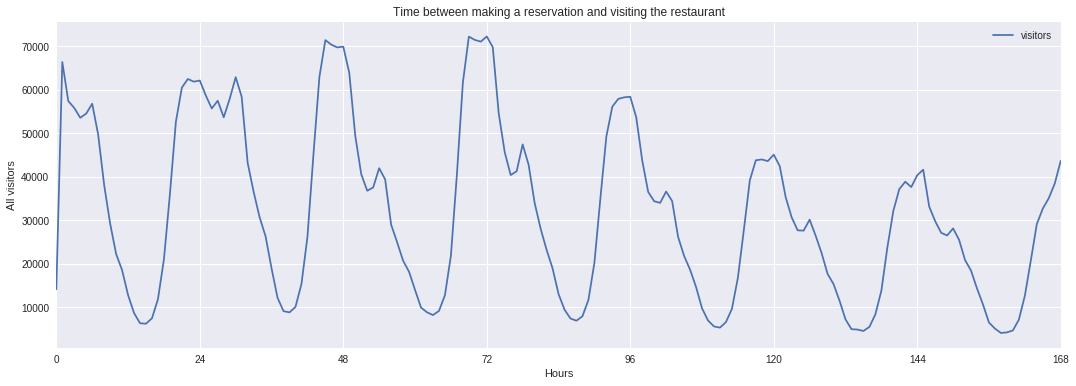

In [35]:
df_hpg_reserve['reserve_visit_diff'] = \
    (df_hpg_reserve['visit_datetime'] - df_hpg_reserve['reserve_datetime']) / np.timedelta64(1, 'h')

hpg_reserve_visit_diff = \
    df_hpg_reserve[df_hpg_reserve['reserve_visit_diff'] <= 7*24][['reserve_visit_diff', 'reserve_visitors']] \
        .groupby(['reserve_visit_diff']) \
        .agg(['sum']) \
        .sort_index(ascending=True)          

# display data
ax = hpg_reserve_visit_diff.plot(figsize=(18,6))

# plot styling
ax.set_title("Time between making a reservation and visiting the restaurant")
ax.set_xlabel("Hours")
ax.set_ylabel("All visitors");
    
ax.legend(['visitors', 'holidays']);

import matplotlib.ticker as ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

#### DATA INTERPRETATION
By looking at data visualization we can find:

* People usually are booking reservations through HPG system around lunch time (12:00), in the evening and night (18:00 - 22:00). Interestingly, no reservation booking was made between 4:00 and 5:00. Apparently there are no early birds in Japan :) 

* Similarly with data from AIR system, the least popular day for booking reservation is Sunday, as probably people are simply spending time with their family.

* Similarly with data from AIR system, the most popular time to sit down at restaurant and dine is 18:00 - 19:00.

* Popularity of the HPG system over time is rather constant, however its popularity peeked around January 2017.

* As we already notices on AIR system data, the time (in hours) between making a reservation and visiting the restaurants follow a nice 24-hour pattern. The most popular strategy is to reserve a couple of hours before the visit, but if the reservation is made more in advance then it seems to be common to book a table in the evening for one of the next evenings.

## Air Store

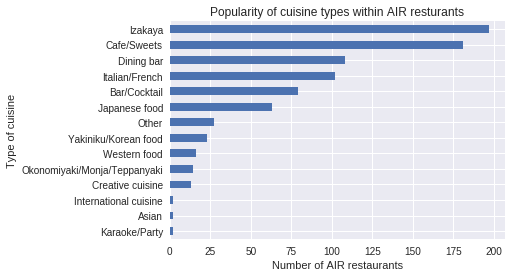

In [36]:
air_by_genre = df_air_store_info['air_genre_name'].value_counts()
      
# display data
ax = air_by_genre.plot(kind='barh');

# plot styling
plt.gca().invert_yaxis()

ax.set_title("Popularity of cuisine types within AIR resturants")
ax.set_xlabel("Number of AIR restaurants")
ax.set_ylabel("Type of cuisine");

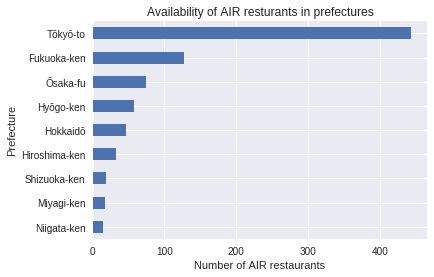

In [37]:
# create new column
df_air_store_info['prefecture'] = \
    df_air_store_info['air_area_name'].str.split('\s+').str[0]

air_by_prefecture = df_air_store_info['prefecture'].value_counts()

# display data
ax = air_by_prefecture.plot(kind='barh');

# plot styling
plt.gca().invert_yaxis()

ax.set_title("Availability of AIR resturants in prefectures")
ax.set_xlabel("Number of AIR restaurants")
ax.set_ylabel("Prefecture");

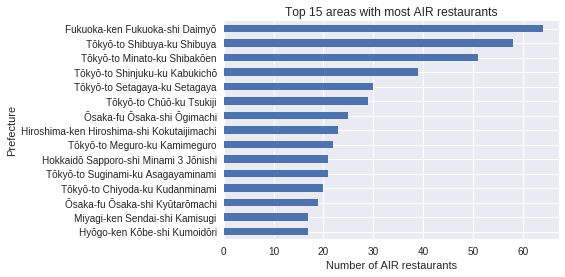

In [38]:
top_15_air_areas = df_air_store_info['air_area_name'] \
    .value_counts() \
    .head(15)

# display data
ax = top_15_air_areas.plot(kind='barh');

# plot styling
plt.gca().invert_yaxis()

ax.set_title("Top 15 areas with most AIR restaurants")
ax.set_xlabel("Number of AIR restaurants")
ax.set_ylabel("Prefecture");

#### DATA INTERPRETATION
By looking at data visualization we can find:

* The most popular restaurant type is Izakaya [Wiki](https://en.wikipedia.org/wiki/Izakaya). By watching the [video](https://www.youtube.com/watch?v=DuZQXSFZkPY) I can easily understand why it is so.

* Places with cafe and sweets enjoy similar popularity.

* Out of foreign cuisin types, the most popular ones are Italian and French.

* Interestingly, the Karaoke/Party restaurant type has only 2 two instances in the AIR database. Does it mean such restaurants are not popular in Japan? Or just [Recruit Holding](http://recruit-holdings.com/who/value/) is not focused on that restaurant type?

* Majority (around 450) of restaurants are located in Tokyo, although the area (considered as area within ward within city) with most AIR restaurants is located in Fukuoka (area called 'Fukuoka-ken Fukuoka-shi Daimyō')

## HPG Store

In [39]:
df_hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


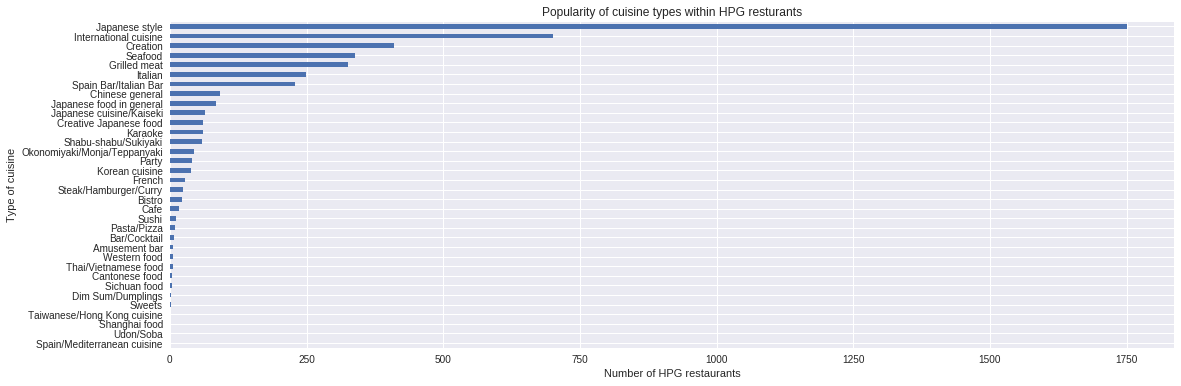

In [40]:
hpg_by_genre = df_hpg_store_info['hpg_genre_name'].value_counts()
      
# display data
ax = hpg_by_genre.plot(kind='barh', figsize=(18,6));

# plot styling
plt.gca().invert_yaxis()

ax.set_title("Popularity of cuisine types within HPG resturants")
ax.set_xlabel("Number of HPG restaurants")
ax.set_ylabel("Type of cuisine");

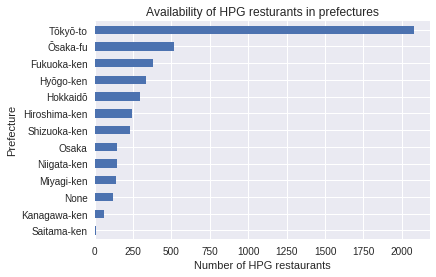

In [41]:
# create new column
df_hpg_store_info['prefecture'] = \
    df_hpg_store_info['hpg_area_name'].str.split('\s+').str[0]

hpg_by_prefecture = df_hpg_store_info['prefecture'].value_counts()

# display data
ax = hpg_by_prefecture.plot(kind='barh');

# plot styling
plt.gca().invert_yaxis()

ax.set_title("Availability of HPG resturants in prefectures")
ax.set_xlabel("Number of HPG restaurants")
ax.set_ylabel("Prefecture");

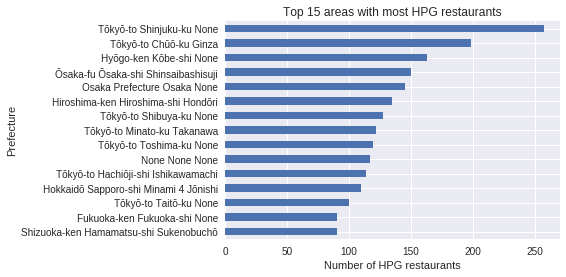

In [42]:
top_15_hpg_areas = df_hpg_store_info['hpg_area_name'] \
    .value_counts() \
    .head(15)

# display data
ax = top_15_hpg_areas.plot(kind='barh');

# plot styling
plt.gca().invert_yaxis()

ax.set_title("Top 15 areas with most HPG restaurants")
ax.set_xlabel("Number of HPG restaurants")
ax.set_ylabel("Prefecture");

#### DATA INTERPRETATION
By looking at data visualization we can find:

* The HPG dataset brings a larger variety of restaurant types than in the Air dataset. The most popular one is 'Japanese style' that, most likely, contains more specific categories such as ones in Air dataset.

* The most of HPG restaurants are located in Tokyo, and two areas with highest density are placed just there.

# Feature relations

## Visitors per restaurant genre

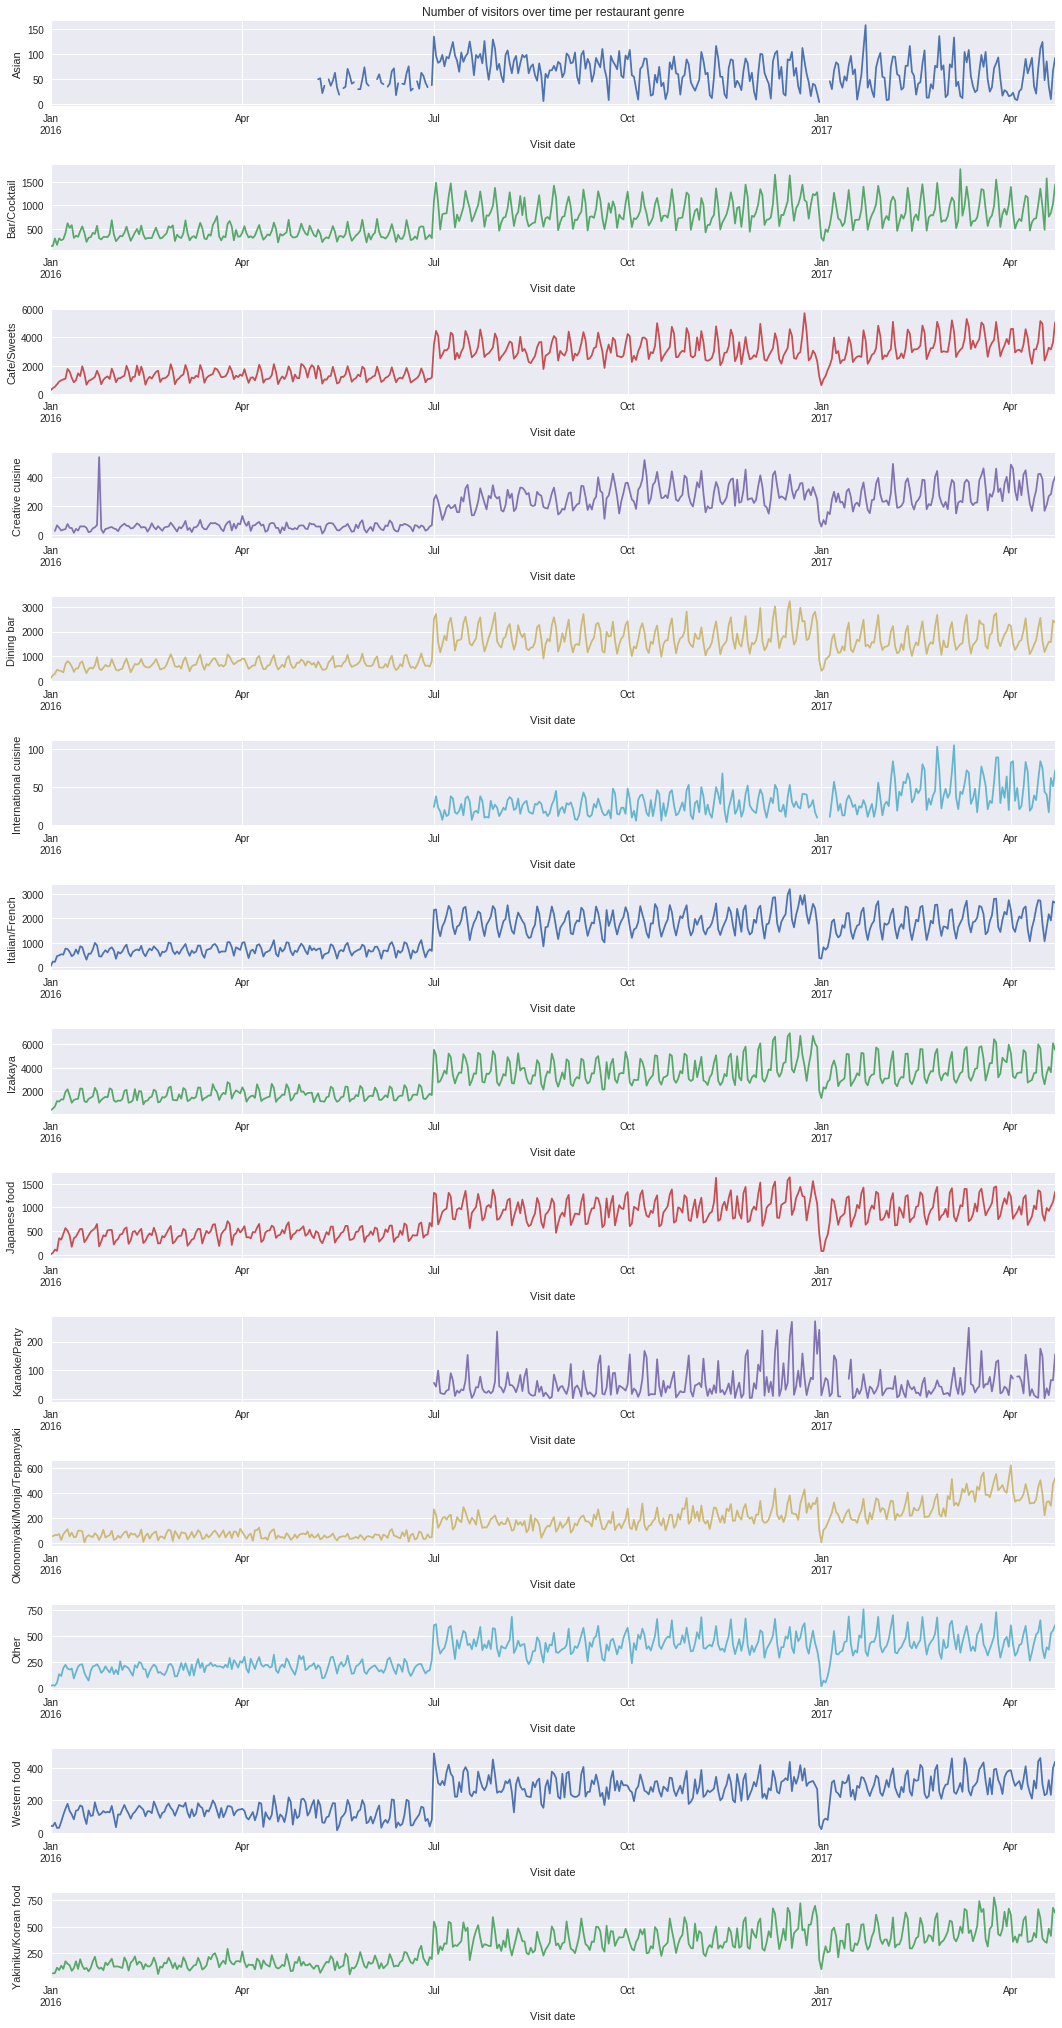

In [43]:
air_visits_store = pd.merge(df_air_visit_data, 
                             df_air_store_info, 
                             how='left',
                             on=['air_store_id'])

air_visits_store_group = \
    air_visits_store[['air_genre_name', 'visit_date', 'visitors']] \
        .groupby(['air_genre_name', 'visit_date']) \
        .agg(['sum'])

# display data
sharey = False
axes = air_visits_store_group.unstack(level=0) \
        .plot(subplots=True, figsize=(18,36), sharey=sharey, sharex=False, legend=False);

# plot styling
for idx, column in enumerate(air_visits_store_group.unstack(level=0).columns):
    axes[idx].set_ylabel(column[2])
    axes[idx].set_xlabel('Visit date')
    
axes[0].set_title('Number of visitors over time per restaurant genre');
plt.subplots_adjust(hspace=0.7)